In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # For customizing the suabplots spacing
import pandas as pd
import os

In [2]:
from sklearn.decomposition import FastICA
import scipy
import scipy.signal as scsig

In [3]:
from synchronization import Synchronizer

## Steps for synchronization
- (0) Load the metadata (Versuchstabelle) -> to identify the file names (soundbook, QASS)
- (1) Load the synchro signals 
    - Dewetron
    - IDMT data, ch3 
- (2) Interpolate the Dewetron signal (to compensate the different sampling rate)
    - (2-0) ICA to increase the SNR
    - (2-1) Linear interpolation
- (3) Cross-correlate the interpolated Dewetron signal and the IDMT data
- (4) Identify the delay (i.e. peak)

## (0) Load the meta data (Versuchstabelle) -> for file names

In [5]:
path_meta = '/Volumes/Sandisk_SD/Work/IZFP/Laser/05_2023_iHub/00_Versuchsplan_iHub.xlsx'
metadf = pd.read_excel(
    path_meta,
    sheet_name=1,
    usecols="B:F",
    nrows=71
)

## Example

In [6]:
# Path to the data
path_dew = '/Volumes/Sandisk_SD/Work/IZFP/Laser/05_2023_iHub/01_DEWETRON_csv'
path_idmt = '/Volumes/Sandisk_SD/Work/IZFP/Laser/05_2023_iHub/03_Soundbook'

# Example trial
dataID = 20
row = dataID - 1
fname_dew = metadf['DEWETRON'][row]
fname_idmt = metadf['SoundBook'][row]
fname_izfp = metadf['QASS'][row]

In [7]:
#---- Synchronize
synch = Synchronizer()
# (1) Load
# IDMT data
t_idmt, s_idmt = synch.load_hd5(path_idmt, fname_idmt) # zero-meaned and normalized
# Dewetron data
t_dew, s_dew = synch.load_dew(path_dew, fname_dew)
# Zero-mean and normalize
s_dew = s_dew - np.mean(s_dew)
s_dew = s_dew/np.abs(s_dew).max()
# (2) Denoise
s_ica = synch.denoise_ica(s_dew)
# (3) Interpolate
t_interp, s_interp = synch.interpolate(t_dew, s_ica, t_idmt, synch.fs_idmt)
#------------------
# -> for special case: trials without pre- and post-trigger (dataID:27, 28, 29)
#s_ica = s_dew[:synch.N]
#t_interp, s_interp = synch.interpolate(t_dew, s_ica, t_idmt[int(synch.T_synch*synch.fs_idmt)+1:], synch.fs_idmt)
#------------------
# (4) Identify the delay
delay, N_offset, corr, tau = synch.identify_delay(s_interp, s_idmt, synch.fs_idmt, ret_corr=True)
    

Synchronizer: returning the correlation results


## Plot

In [15]:
# Correct the delay and overlap the signals 
#%matplotlib widget
%matplotlib inline

def save_allplots(save, fname=None):

    # Subplots spacing
    plt.rcParams["figure.figsize"] = [8.0*1.3, 4.50*1.3]#[6.50, 4.50]
    plt.rcParams["figure.autolayout"] = True
    gs1 = gridspec.GridSpec(3, 1)
    gs1.update(wspace=0.0, hspace=0.15)

    # Axis labels
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=False)
    #plt.suptitle(f'Delay correction of {fname_dew}: {round(delay*10**3, 3)}ms delay')
    plt.subplots_adjust(hspace=0.6) # more spacing between rows

    # Before
    ax0.plot(t_dew, s_dew, label='DEW')
    ax0.plot(t_idmt, s_idmt, label='SB')
    ax0.set_xlabel('Aufnahmezeit [s]')
    ax0.set_ylabel('[V]')
    ax0.legend(loc='upper right')
    ax0.grid(True)
    ax0.set_xlim(-0.5, 2.5)

    # After
    ax1.sharex(ax0)
    ax1.plot(t_dew, s_dew, label='DEW')
    ax1.plot(t_idmt-delay, s_idmt, label= f'SB')
    ax1.set_xlabel('Aufnahmezeit [s]')
    ax1.set_ylabel('[V]')
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Cross-correlation results
    _corr = corr/np.abs(corr).max()
    ax2.plot(tau, _corr, label='cross correlation')
    peaks = delay
    ax2.vlines(x=peaks, ymin=_corr.min(), ymax=_corr.max(), linestyles='--', color='r')
    ax2.set_xlabel('Versatz [s]')
    ax2.set_ylabel(r"[$V^2$]")
    #ax2.legend(loc='upper right')
    xticks = np.sort(np.concatenate((np.array([peaks]), np.array([-1.0, 1.0, 2.0, 3.0, 4.0]))))
    ax2.set_xticks(xticks)
    ax2.grid(True)

    if save == True:
        # Parameters for savefig
        # dpi > 150 does not yield any perceptible difference in resolution 
        # bbox_inches: bounding box to determine the area to be saved => use 'tight', otherwise including a weird white space
        # pad_inches: margine to be padded, if bbox_inches == 'tight'
        plt.savefig(
            fname, 
            dpi=1400, 
            bbox_inches = 'tight', 
            pad_inches = 0.1 #pad_inches = 0.05
        ) 

    plt.show()
    

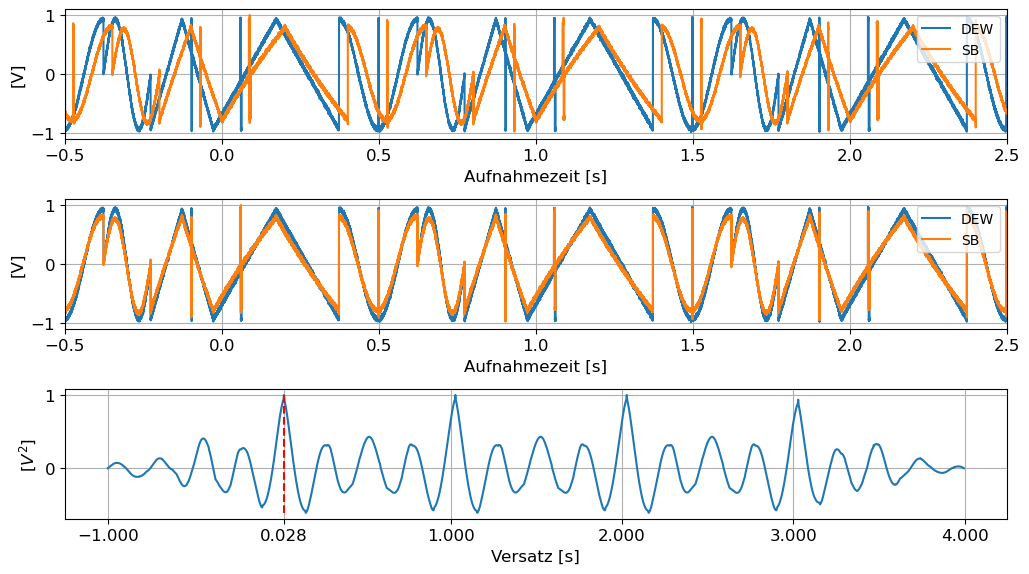

In [16]:
save_allplots(save=True, fname='plots/SoundBook_synchronization.png')

In [9]:
delay

0.028208008

In [ ]:
def save_plot(x_list, y_list, legend_list, title, fname,
              save=False, legend=True, figwidth=9, figheight=1.3):
    """
    Parameters
    ----------
        x_list: list containing N vectors of length M
            x values for plotting. It can contain multiple vectors.
            N = number of signals to show in one plot
            M = number of time samples
        y_list: list containing N vectors of length M
            y values for plotting. It can contain multiple vectors.
            N = number of signals to show in one plot
            M = number of time samples
    """
    fig, ax = plt.subplots(1, 1)
    # Figure size
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)

    # Plot
    for (x, y, label) in zip(x_list, y_list, legend_list):
        ax.plot(x, y, label=label)

    # Title
    ax.title.set_text(title)
    # Labels
    #ax.set_xlabel('Zeit [s]')
    #ax.set_ylabel('Amplitude [V]')
    # x limit
    ax.set_xlim(left=-0.5, right=1.5)

    # Grid
    ax.grid(True)
    # Legends
    if legend == True:
        ax.legend(loc='upper right')


    if save == True:
        # Parameters for savefig
        # dpi > 150 does not yield any perceptible difference in resolution 
        # bbox_inches: bounding box to determine the area to be saved => use 'tight', otherwise including a weird white space
        # pad_inches: margine to be padded, if bbox_inches == 'tight'
        plt.savefig(
            fname, 
            dpi=250, 
            bbox_inches = 'tight', 
            pad_inches = 0.1 #pad_inches = 0.05
        ) 

    plt.show()

In [ ]:
# Synchsignal
# Font size
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

save_plot(
    [t_dew], [s_dew], ['DEW'], 'Synchsignal', fname='ihub_synchsig.png',
    save=False, legend=False, figwidth=9, figheight=1.3
)

In [ ]:
# DEW vs SoundBook: before correction
# Font size
plt.rcParams['axes.titlesize'] = 16 
plt.rcParams['axes.labelsize'] = 16 
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16 
plt.rcParams['legend.fontsize'] = 'Large'
plt.rcParams['lines.linewidth'] = 1.6


save_plot(
    x_list=[t_dew, t_idmt], 
    y_list=[s_dew, s_idmt], 
    legend_list=['HV-CAM', 'SoundBook'], 
    title=None, #'Rohdaten',#f'{fname_dew}: before delay correction', 
    fname='plots/ihub_soundbook_presynch.png',
    save=True, 
    legend=True,
    figwidth=6.5, figheight=1.3
)

In [ ]:
delay

## Statistics of the delays

In [ ]:
df_delays = pd.read_csv(
    '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/04_Delays/delays_SoundBook.csv'
)

In [ ]:
# Average delay between Soundbook and Dewetron
print('Mean:')
print(df_delays['delay[s]'].mean())
print('Std:')
print(df_delays['delay[s]'].std())

In [ ]:
print('Outlier:')
print(df_delays['DEWETRON'][63])
print(df_delays['delay[s]'][63])

In [ ]:
new_df = df_delays.drop(index=63)
# Average delay without the outlier
print(new_df['delay[s]'].mean())

In [ ]:
new_df['delay[s]'].std()